# Libraries

In [2]:
import cooler
import bbi
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import cooltools
import bioframe

import tqdm

import pandas as pd
import numpy as np
import multiprocess as mp

import seaborn as sns
import matplotlib.pyplot as plt

/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


# Prepare Data

### Eigen

In [3]:
RESOLUTION = 25_000
NPROC = 4
SAMPLES = [0, 12, 30, 60]
res_readeble = RESOLUTION // 1_000

phasing_option = "gc"
q_range = (0.05, 0.975)

rna_s1 = "0"
rna_s2 = "12"
ev_s1 = "0"
ev_s2 = "12"


ev_mapping = {
    "gc": "",
    "pol": "_pol",
}
phasing_name = ev_mapping[phasing_option]
ev_bins_df = pd.read_csv(f"e1_{res_readeble}kb{phasing_name}.tsv", sep="\t")

In [4]:
from cooltools.api.saddle import _make_binedges

def digitize(track_values, n_bins, vrange=None, qrange=None):
    binedges, lo, hi = _make_binedges(
        track_values, n_bins, vrange=vrange, qrange=qrange
    )
    digits = np.digitize(track_values, binedges, right=False).astype(float)
    d_range = range(1, n_bins + 1)
    digits = pd.Series(digits)
    digits.loc[~digits.isin(d_range)] = pd.NA
    return digits

In [5]:
n_bins = 1000
for i, sample in enumerate(SAMPLES):
    vec = ev_bins_df[f'E1_{sample}'].copy().to_numpy()
    
    vec = vec - np.nanmean(vec)

    digits = digitize(vec, n_bins, qrange=q_range)
    ev_bins_df[f"E1_{sample}"] = digits
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    ev_bins_df[f"E1_{sample}"] = scaler.fit_transform(ev_bins_df[f"E1_{sample}"].values.reshape(-1, 1))
    
ev_bins_df.dropna(subset=[f"E1_{sample}" for sample in SAMPLES], inplace=True, how="all")

In [6]:
gtf = "/home/carlos/oldies/manuscripts/notebooks/unibind/GRCh38.gtf"
genes_all_only = bioframe.read_table(gtf, schema='gtf').query('feature=="gene"') # not CDS
genes_all_only.start = genes_all_only.start.astype(int)
genes_all_only.end = genes_all_only.end.astype(int)
genes_all_only.sort_values(by=['chrom', 'start'], inplace=True)
genes_all_only['gene_id'] = [gene_id.split(".")[0] for gene_id in genes_all_only.attributes.str.extract(r'gene_id "(.*?)";', expand=False)]
genes_all_only.sort_values(by=['gene_id'], inplace=True)
genes_all_only.reset_index(drop=True, inplace=True)

gene_level_abundance = pd.read_csv("/home/carlos/oldies/manuscripts/review/gene_level_tpm.tsv", sep='\t')
gene_level_abundance['gene_id'] = gene_level_abundance['gene_id'].str.split('.').str[0]
gene_level_abundance['chrom'] = genes_all_only['chrom']
gene_level_abundance['start'] = genes_all_only['start']
gene_level_abundance['end'] = genes_all_only['end']

assert gene_level_abundance.gene_id.to_list() == genes_all_only.gene_id.to_list()
assert len(gene_level_abundance.chrom) == len(genes_all_only)

gene_level_abundance = gene_level_abundance[['chrom', 'start', 'end', 'gene_id'] + gene_level_abundance.columns[:12].to_list()]

chrom_names = [f'chr{i}' for i in range(1, 23)] + ['chrX']

gene_level_abundance = gene_level_abundance.loc[gene_level_abundance.chrom.isin(chrom_names)]
gene_level_abundance = bioframe.sort_bedframe(gene_level_abundance)

In [7]:
overlap = bioframe.overlap(ev_bins_df, gene_level_abundance, return_overlap=True)
overlap['gene_size'] = overlap.end_ - overlap.start_
overlap['overlap_size'] = overlap.overlap_end - overlap.overlap_start
overlap['tpm_sf'] = overlap['overlap_size'] / overlap['gene_size']
overlap.loc[overlap.overlap_size == RESOLUTION, 'tpm_sf'] = 1

In [8]:
replicates_cols = [f'{rep_id + sample}_' for sample in SAMPLES for rep_id in [100, 200, 300]]

scaled_tpm = overlap[replicates_cols].apply(lambda x: x * overlap.tpm_sf, axis=0)

replicates_cols_grouped = [[f'{rep_id + sample}_' for rep_id in [100, 200, 300]] for sample in SAMPLES ]

merged_df = pd.concat([overlap.iloc[:, :8], scaled_tpm], axis=1)

scaled_tpm_ind = []

import tqdm

for i, subset_df in tqdm.tqdm(merged_df.groupby('bin_idx').__iter__(), total=merged_df.bin_idx.nunique()):
    
    local_df= pd.DataFrame({
        'chrom': subset_df.chrom.iloc[0],
        'start': subset_df.start.iloc[0],
        'end': subset_df.end.iloc[0],
        'bin_idx': subset_df.bin_idx.iloc[0],
        'E1_0': subset_df.E1_0.iloc[0],
        'E1_12': subset_df.E1_12.iloc[0],
        'E1_30': subset_df.E1_30.iloc[0],
        'E1_60': subset_df.E1_60.iloc[0],
    }, index=[0])

    for j, rep_cols in enumerate(replicates_cols_grouped):
        local_df[f'RNA_{SAMPLES[j]}'] = subset_df[rep_cols].sum(axis=0).mean(axis=0)

    scaled_tpm_ind.append(local_df)

scaled_tpm_ind = pd.concat(scaled_tpm_ind)

100%|██████████| 107568/107568 [04:34<00:00, 392.25it/s]


In [9]:
final_df = scaled_tpm_ind.copy()

In [10]:
final_df.dropna(subset=["E1_0","E1_12", "RNA_0", "RNA_12"], inplace=True, how="any")

In [11]:
final_df = pd.DataFrame({
    "EV": final_df["E1_0"].to_list() + final_df["E1_12"].to_list(),
    "RNA": final_df["RNA_0"].to_list() + final_df["RNA_12"].to_list(),
    "Sample": ["Control"] * len(final_df) + ["12 min"] * len(final_df)
})

In [12]:
def assign_to_windows(arr, windows):
    group_idx = {k: np.nan for k in range(len(arr))}
    for idx_i, val in enumerate(arr):
        is_assigned = False
        for idx_w, window in enumerate(windows):
            if val >= window[0] and val < window[1]:
                is_assigned = True
                break
            
        group_idx[idx_i] = idx_w if is_assigned else np.nan
        
    return [group_idx[k] for k in range(len(arr))]

windows = [(0, 0.1), (0.1, 1), (1, 10), (10, 100), (100, 1_000), (1_000, 1_000_000)]

In [13]:
final_df['window'] = assign_to_windows(final_df.RNA, windows)
final_df['window'] += 1
final_df.loc[final_df.RNA == 0, 'window'] = 0

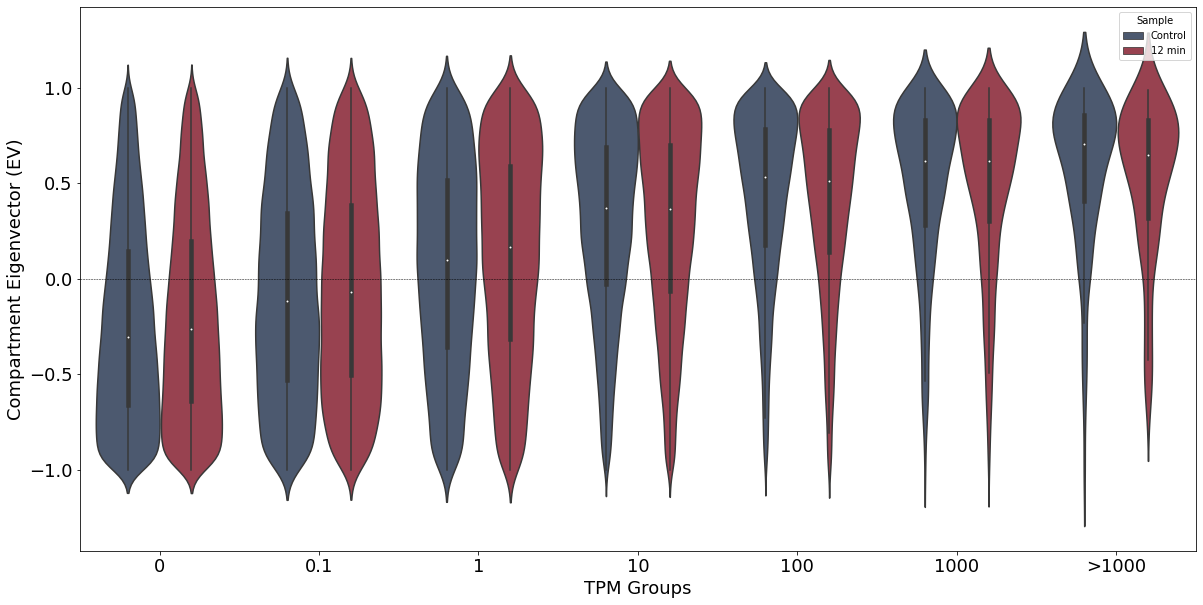

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.violinplot(data=final_df, x="window", y="EV", hue="Sample", split=False, palette=['#465775', '#A63446'], dodge=True, linewidth=1.5, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

ax.set_xlabel("TPM Groups", fontsize=18)
ax.set_ylabel("Compartment Eigenvector (EV)", fontsize=18)

ax.set_xticks([0,1,2,3,4,5,6], labels=[0, 0.1, 1, 10, 100, 1000, ">1000"], fontsize=18)

ax.axhline(0, color='black', lw=.5, ls='--')

fig.savefig(f"figs/e1_{res_readeble}kb{phasing_name}_tpm_groups.png", bbox_inches='tight', dpi = 300)
fig.savefig(f"figs/e1_{res_readeble}kb{phasing_name}_tpm_groups.svg", bbox_inches='tight')


In [15]:
final_df.window.value_counts().sort_index()

0    86967
1    28027
2    20741
3    32917
4    21017
5     2448
6      255
Name: window, dtype: int64